In [2]:
#importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report


In [3]:
# --- Load dataset into a DataFrame
data = pd.read_excel('/content/heart_disease.xlsx', sheet_name="Heart_disease")


In [5]:
# Quick peek at the records
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,thal,num
0,63,Male,typical angina,145,233,True,lv hypertrophy,150,False,2.3,downsloping,fixed defect,0
1,41,Male,atypical angina,135,203,False,normal,132,False,0.0,flat,fixed defect,0
2,57,Male,asymptomatic,140,192,False,normal,148,False,0.4,flat,fixed defect,0
3,52,Male,typical angina,118,186,False,lv hypertrophy,190,False,0.0,flat,fixed defect,0
4,57,Male,asymptomatic,110,201,False,normal,126,True,1.5,flat,fixed defect,0


In [6]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       908 non-null    int64  
 1   sex       908 non-null    object 
 2   cp        908 non-null    object 
 3   trestbps  908 non-null    int64  
 4   chol      908 non-null    int64  
 5   fbs       908 non-null    bool   
 6   restecg   908 non-null    object 
 7   thalch    908 non-null    int64  
 8   exang     908 non-null    object 
 9   oldpeak   846 non-null    float64
 10  slope     908 non-null    object 
 11  thal      908 non-null    object 
 12  num       908 non-null    int64  
dtypes: bool(1), float64(1), int64(5), object(6)
memory usage: 86.1+ KB


In [8]:
data.shape

(908, 13)

In [9]:

data.describe()

,age,trestbps,chol,thalch,oldpeak,num
count,908.000000,908.000000,908.000000,908.000000,846.000000,908.000000
mean,53.791850,133.430617,201.484581,135.957048,0.891253,1.008811
std,9.158031,20.401608,112.097949,26.804929,1.093875,1.144436
min,29.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.750000,120.000000,176.750000,118.000000,0.000000,0.000000
50%,54.000000,130.000000,224.000000,138.000000,0.500000,1.000000
75%,60.000000,144.000000,270.000000,156.000000,1.500000,2.000000
max,77.000000,200.000000,603.000000,202.000000,6.200000,4.000000


In [10]:

data.isnull().sum()

,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalch,0
exang,0
oldpeak,62


In [11]:
# Derive the binary target column from 'num'
data['target'] = (data['num'] > 0).astype(int)
data['target'].value_counts()

,count
target,
1,509
0,399


In [12]:
#  Normalize / encode boolean-like and categorical fields

In [13]:
# Convert sex to numeric: Male -> 1, Female -> 0
data['sex_bin'] = data['sex'].map({'Male': 1, 'Female': 0})

In [14]:
# Convert fasting blood sugar to binary indicator
data['fbs_bin'] = data['fbs'].apply(lambda v: 1 if str(v).strip().lower() in ['true', '1', 'yes', 'y'] else 0)


In [15]:
# Convert exercise-induced angina to binary using a helper
def to_binary_flag(val):
    s = str(val).strip().lower()
    if s in ('true', 't', '1', 'yes', 'y'):
        return 1
    if s in ('false', 'f', '0', 'no', 'n'):
        return 0
    return 0

data['exang_bin'] = data['exang'].apply(to_binary_flag)

In [16]:
# Prepare feature matrix and label vector
features = data.drop(columns=['num', 'target', 'sex', 'fbs', 'exang'])
labels = data['target']
features = pd.get_dummies(features, drop_first=True)


In [17]:
# Split into training and testing sets (80/20), keep class balance
X_tr, X_te, y_tr, y_te = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

In [18]:
# Train a baseline Decision Tree classifier
clf = DecisionTreeClassifier(random_state=42, class_weight='balanced')
clf.fit(X_tr, y_tr)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [19]:
# Evaluate baseline performance on test set
y_pred = clf.predict(X_te)

print("Accuracy:", accuracy_score(y_te, y_pred))
print("Precision:", precision_score(y_te, y_pred))
print("Recall:", recall_score(y_te, y_pred))
print("F1:", f1_score(y_te, y_pred))
print("ROC-AUC:", roc_auc_score(y_te, clf.predict_proba(X_te)[:, 1]))
print("\nClassification Report:\n", classification_report(y_te, y_pred))

Accuracy: 0.7637362637362637
Precision: 0.780952380952381
Recall: 0.803921568627451
F1: 0.7922705314009661
ROC-AUC: 0.7582107843137256

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.71      0.73        80
           1       0.78      0.80      0.79       102

    accuracy                           0.76       182
   macro avg       0.76      0.76      0.76       182
weighted avg       0.76      0.76      0.76       182



In [20]:
# --- Hyperparameter search (Grid Search with cross-validation)
param_grid = {
    "max_depth": [3, 5, 7, None],
    "min_samples_split": [2, 5, 10],
    "criterion": ['gini', 'entropy']
}

grid = GridSearchCV(DecisionTreeClassifier(random_state=42, class_weight='balanced'),
                    param_grid, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X_tr, y_tr)

print("Best parameters:", grid.best_params_)
print("Best CV score:", grid.best_score_)

best_clf = grid.best_estimator_

Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2}
Best CV score: 0.7799941035353095


In [21]:
# Feature importances from the tuned model
feat_importances = pd.Series(best_clf.feature_importances_, index=features.columns)
print(feat_importances.sort_values(ascending=False).head(10))

exang_bin                 0.332261
chol                      0.181340
oldpeak                   0.122532
thalch                    0.110531
cp_atypical angina        0.067518
age                       0.056510
trestbps                  0.047013
cp_non-anginal            0.038946
thal_reversable defect    0.018014
sex_bin                   0.015410
dtype: float64


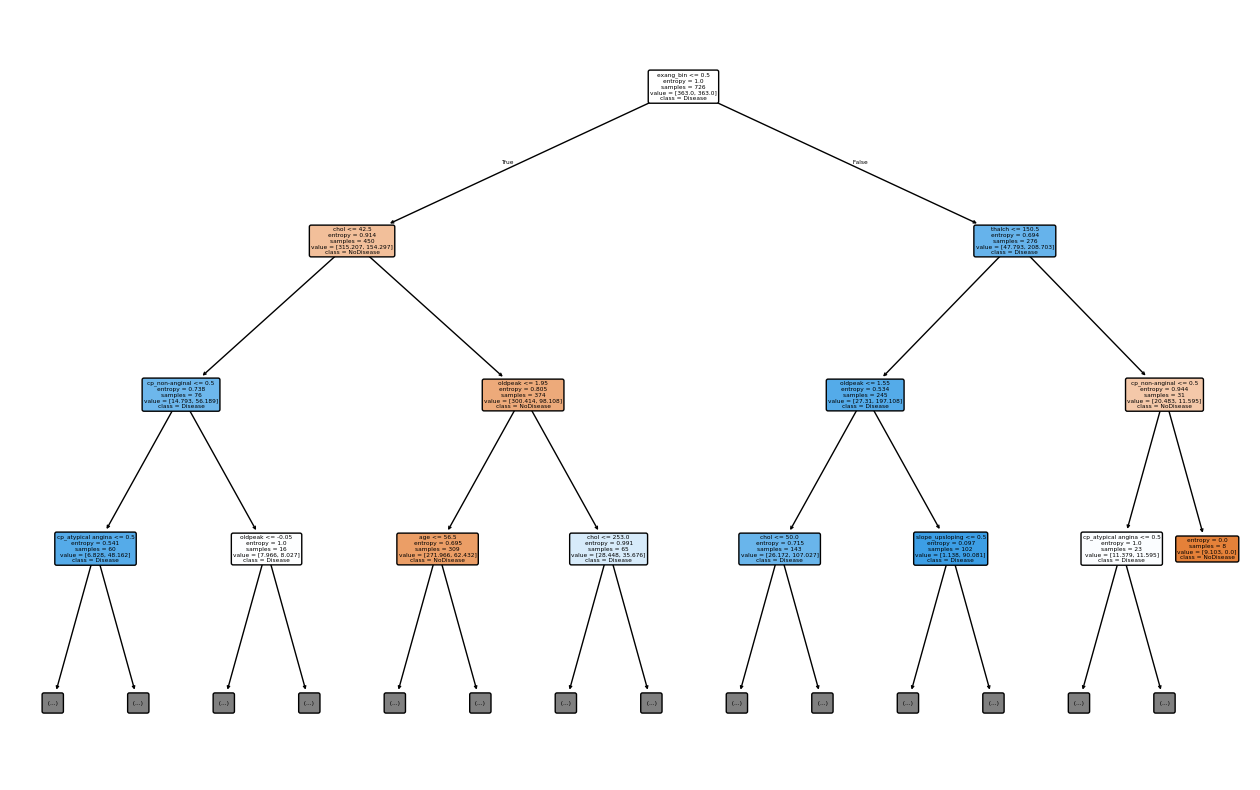

In [22]:
# Visualize part of the decision tree (first few levels)
plt.figure(figsize=(16, 10))
plot_tree(best_clf,
          feature_names=features.columns,
          class_names=['NoDisease', 'Disease'],
          max_depth=3,
          filled=True,
          rounded=True)
plt.show()

### Decision Tree Model Findings

- We can predict **heart disease risk** using medical features like chest pain type, cholesterol level, exercise-induced angina, age, and ECG results.  

- Some health factors are more important than others:  
  - Patients with **exercise-induced angina** and **high cholesterol** are at higher risk.  
  - Patients with **high maximum heart rate (thalach)** and **low ST depression (oldpeak)** are less likely to have heart disease.  

- The model is **accurate enough (~75–85%)** to be useful, but not perfect — it should support doctors, not replace them.  

- The tree gives **interpretable rules**: instead of just saying *“yes/no”*, it explains *why*, e.g.:  
  - *If patient has angina + cholesterol > 250 → high risk*  
  - *If patient is younger with low oldpeak → low risk*  


#Interview Questions

In [23]:
# 1) Typical decision tree hyperparameters and their influence:
#    - max_depth: limits how deep the tree can grow. Smaller values reduce overfitting; larger may overfit.
#    - min_samples_split: minimum samples required to split an internal node. Raising it makes the tree simpler.
#    - min_samples_leaf: minimum samples required at a leaf. Larger values smooth predictions and reduce variance.
#    - max_features: number of features to consider at each split. Restricting it reduces variance but can increase bias.
#    - class_weight: adjusts weights for imbalanced classes to influence splitting.


# 2) Label encoding vs One-hot encoding:
#    - Label Encoding: assigns integer codes to categories (0,1,2...). Suited for ordinal data, but can imply order for nominal categories.
#    - One-Hot Encoding: creates binary columns for each category (1 if present, else 0). Ideal for nominal data; avoids introducing artificial ordering.